In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import nltk


import re

import spacy
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer


from gensim import corpora
import pickle
import gensim
import pyLDAvis.gensim

from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import glob


from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [215]:
# To update 

#nltk.download('stopwords')
#nltk.download('wordnet')


# Steps for Preprocessing

1. Tokenize text - split up by word
2. Remove stopwords
3. Lemmatize to get the root word

# About the Data

- No quantitative features! We can consider some by aggregating by categories later.

# Limitations

- Inconsistency in which features are included. There are many null values throughout the data
- Very inconsistent/sparse Salary column 

### Merging separate data files (only for indeed for now)

In [216]:
df_main = pd.DataFrame()

files = glob.glob('data' + "/indeed*.csv")
# files = glob.glob('data' + "/*.csv")

for i,file in enumerate(files):
    df = pd.read_csv(file)
    m = re.search(r'/\w*\W*\d\W\d', file)
    filename= m.group()
    search_date = filename[len(filename)-3:len(filename)]
    platform = re.search(r'\w+', filename).group()
    
    df['platform'] = len(df)*[platform]
    df['search_date'] = len(df)*[search_date]
    

    frames = [df_main, df]
    df_main = pd.concat(frames)
    
    
    #print(this_file)
    #values.append((list(df.iloc[len(df)-1,].values)))
    #keys = keys + int(len(df)+1)
    #print(list(df.iloc[len(df)-1,].values))
    

    #keys.append(file[12:17])
    #print(file[12:17])
    #values.append((list(this_file.iloc[len(this_file)-1,].values)))
#keys = list(range(keys))

In [217]:
df = df_main
df.isnull().sum()

company          54
location          0
title             0
post_date        46
salary         2332
description       1
url               0
search_role       0
platform          0
search_date       0
dtype: int64

In [218]:
# Look for the one null value in description column

df[df['description'].isnull()].index

Int64Index([328], dtype='int64')

In [219]:
'''Drop the row that has null value in description'''

df = df.dropna(subset=['description'])

In [220]:
df.isnull().sum()


company          53
location          0
title             0
post_date        45
salary         2331
description       0
url               0
search_role       0
platform          0
search_date       0
dtype: int64

In [7]:
df.head()

company            location  \
0                      Noom Inc.        New York, NY   
1  Strategic Financial Solutions  New York, NY 10018   
2                        Averity        New York, NY   
3              Lenmar Consulting  Woodcliff Lake, NJ   
4       Memorial Sloan Kettering  New York, NY 10017   

                                               title post_date  \
0                                     Data Engineer        30+   
1                               Lead Data Scientist         18   
2                             Manager, Data Science         12   
3                            Medical Data Scientist          0   
4  Sr Strategic Consultant / Data Scientist (Pati...        16   

                       salary  \
0                         NaN   
1                         NaN   
2  $175,000 - $225,000 a year   
3                 $75 an hour   
4                         NaN   

                                         description  \
0   \n At Noom, we use scientifically proven meth...   
1   \n Overview\nDo you love numbers and finding ...   
2   \n We are one of the world's premiere travel ...   
3   \n Medical Data Scientist \n Must have at lea...   
4   \n <h2 class="jobSectionHeader">Company Overv...   

                                                 url     search_role platform  \
0  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   
1  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   
2  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   
3  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   
4  https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...  Data Scientist   indeed   

  search_date  
0         8-5  
1         8-5  
2         8-5  
3         8-5  
4         8-5

In [221]:
# Create English parser
#spacy.load('en')
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('\n'):
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [222]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
        print(lemma)
    
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [223]:
# List of stopwords to upload
en_stop = set(nltk.corpus.stopwords.words('english'))


In [224]:
desc_tokens = []

for index, row in df.iterrows():    
    tokens = tokenize(row['description'])
    #print(index)
    # Filters tokens to only words of length 4 or more
    tokens = [token for token in tokens if len(token) > 4]
    # Filters tokens that are in list of stopwords
    tokens = [token for token in tokens if token not in en_stop]
    # Lemmatizes tokens to their roots
    tokens = [get_lemma(token) for token in tokens]
    desc_tokens.append(tokens)

df['desc_tokens'] = desc_tokens

/Users/ckato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
df

company             location  \
0                             Noom Inc.         New York, NY   
1         Strategic Financial Solutions   New York, NY 10018   
2                               Averity         New York, NY   
3                     Lenmar Consulting   Woodcliff Lake, NJ   
4              Memorial Sloan Kettering   New York, NY 10017   
5                            Digitalogy         New York, NY   
6                                Viacom   New York, NY 10036   
7                     Butterfly Network         New York, NY   
8                               Celonis   New York, NY 10036   
9                                Macy's   New York, NY 10001   
10                          Squarespace   New York, NY 10014   
11           Remedy BPCI Partners, LLC.         New York, NY   
12                         Getty Images         New York, NY   
13                      Remedy Partners         New York, NY   
14                            Quantilus   New York, NY 10036   
15                             TRANZACT   Fort Lee, NJ 07024   
16                                 81qd   New York, NY 10017   
17                                Apple          Seattle, WA   
18                            eBay Inc.   Bellevue, WA 98009   
19                        Akvelon, Inc.          Redmond, WA   
20                        Akvelon, Inc.   Bellevue, WA 98004   
21          Centrica Business Solutions   Bellevue, WA 98004   
22                                Tesla          Seattle, WA   
23                       Neal Analytics          Redmond, WA   
24                            Starbucks    Seattle, WA 98148   
25                            Microsoft   Bellevue, WA 98004   
26            Amazon.com Services, Inc.          Seattle, WA   
27                            Starbucks    Seattle, WA 98134   
28                        Expedia Group   Bellevue, WA 98004   
29                            Starbucks    Seattle, WA 98134   
..                                  ...                  ...   
100               Washington County, OR        Hillsboro, OR   
101                                BBSI  Vancouver, WA 98662   
102                   CU Business Group   Portland, OR 97220   
103                                 NaN       Ridgefield, WA   
104       Motus Recruiting and Staffing   Portland, OR 97204   
105                         Umpqua Bank   Portland, OR 97258   
106                   City of Vancouver  Vancouver, WA 98660   
107                    CareOregon, Inc.         Portland, OR   
108        Viewpoint, a Trimble Company         Portland, OR   
109            City of Hillsboro Oregon  Hillsboro, OR 97123   
110                         Umpqua Bank   Portland, OR 97258   
111                          PacifiCorp   Portland, OR 97213   
112          Lattice Semiconductor Corp  Hillsboro, OR 97124   
113                          PacifiCorp   Portland, OR 97232   
114     First Tech Federal Credit Union  Hillsboro, OR 97124   
115              Arnerich Massena, Inc.         Portland, OR   
116            Child and Family Service       ‘Ewa Beach, HI   
117                  Kamehameha Schools   Honolulu, HI 96813   
118                                SOSi        United States   
119               American Savings Bank   Honolulu, HI 96817   
120                 Booz Allen Hamilton     Fort Shafter, HI   
121                      Bank of Hawaii      Oahu Island, HI   
122                                 NaN         Honolulu, HI   
123  Hawaii Medical Service Association   Honolulu, HI 96814   
124                 First Hawaiian Bank         Honolulu, HI   
125                 First Hawaiian Bank         Honolulu, HI   
126           Hawaiian Electric Company      Oahu Island, HI   
127                                 NaN         Honolulu, HI   
128                                 NaN     Fort Shafter, HI   
129                                 NaN        United States   

                                                 title post_dat

## To Bin By Search Keyword
Explanation--
I decided to bin the data by the search_role column, as this column will give more consistent results compared to the actual job title postings. 

#### For further analysis, I will take a subset of the data by *ACTUAL* postings that have the title of "data scientist" and "data analyst" that I am looking for.


A few research questions to consider: 
- What is the difference between data scientist roles and data analyst roles.
- Are more data science roles incorporating more software engineering aspects? (as described in ____)
- Which areas/skills are more important? And what subjects/major to focus on in school? -- (ie: computer science/ statistics/ business)
- Is grad school necessary



In [225]:
by_role = df.groupby('search_role')
by_city = df.groupby('location')

In [19]:
for key, item in by_role:
    print(key)
    print(item['title'])

Artificial Intelligence Researcher
771                                  Content Specialist 
772                            Computational Researcher 
773                             Research Scientist (AI) 
774                   Alternative Data Research Analyst 
775                                      Research Intern
776                              Research Engineer (AI) 
777    Research Scientist, Machine Learning and Intel...
778                                     Research Intern 
779                             Visiting Scientist (AI) 
780                                  Research Scientist 
781                          Associate Research Manager 
782                                        Writer/Editor
783                          Applied Research Scientist 
784    Full Time Opportunities for PhD Students or Re...
785    Internship Opportunities for PhD Students: Res...
786            Director of Machine Learning Engineering 
787                                     Research Inte

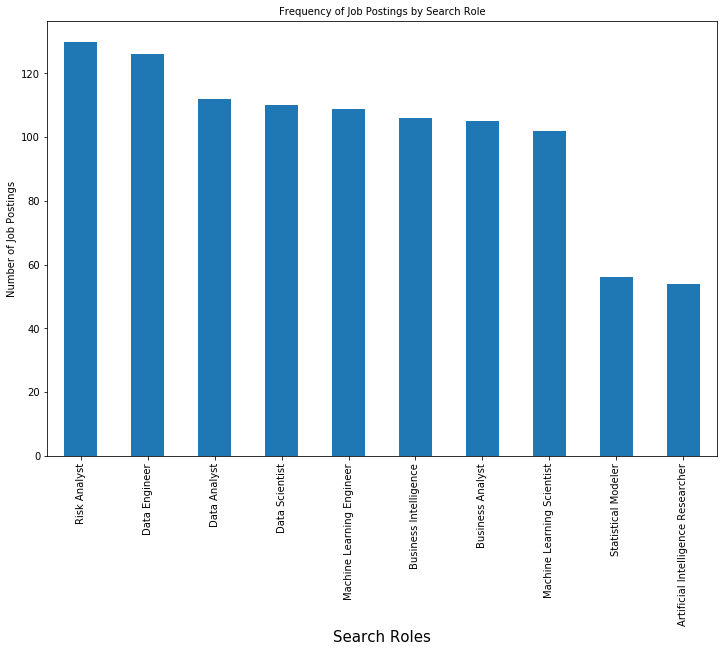

In [35]:
plt.figure(figsize=(12,8))
by_role.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Search Roles", fontsize=15)
plt.ylabel("Number of Job Postings",fontsize=10)
plt.title("Frequency of Job Postings by Search Role", fontsize=10)
plt.xticks(rotation=90)
plt.show()

## Add preprocessing for original search_city 
to run similar visualization as above. 
To create bar plots of CITY x search role

## Add visualization of just data scientist and data analyst roles. 
Search frequency / bar plot by city



## Wordclouds by Role

In [111]:
# List of roles and frequency
by_role.size().sort_values(ascending=False)


search_role
Risk Analyst                          130
Data Engineer                         126
Data Analyst                          112
Data Scientist                        110
Machine Learning Engineer             109
Business Intelligence                 106
Business Analyst                      105
Machine Learning Scientist            102
Statistical Modeler                    56
Artificial Intelligence Researcher     54
dtype: int64

In [198]:
def group_descriptions(by_role):
    '''Creates concatenated/joined text for job descriptions for each search role'''
    roles = []
    merged_desc = []
    for key, items in by_role.indices.items():        
        
        # concatenate strings in descriptions column (by search_role grouping) and append to list of merged descriptions
        string=(" ").join(description for description in df.iloc[items,5])
        merged_desc.append(string)
        
        roles.append(key)

    return merged_desc, roles


descriptions, roles = group_descriptions(by_role)

#listed_descriptions = list(df.iloc[items,5])


Search Role:  Artificial Intelligence Researcher


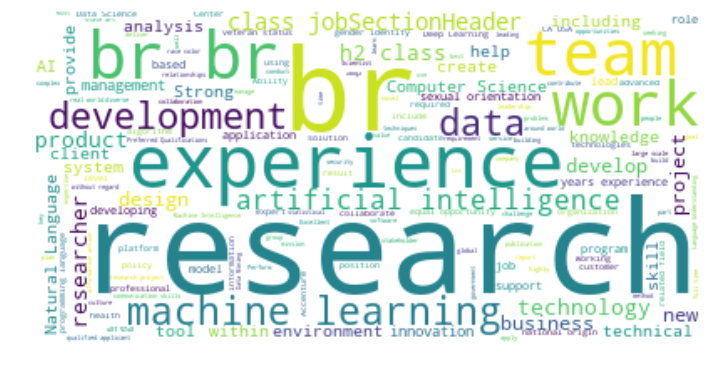

Search Role:  Business Analyst


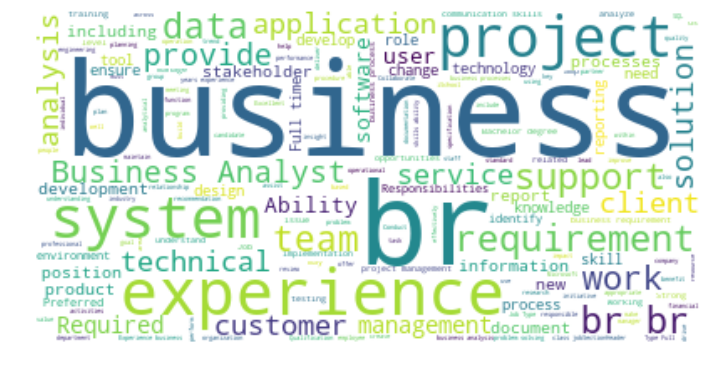

Search Role:  Business Intelligence


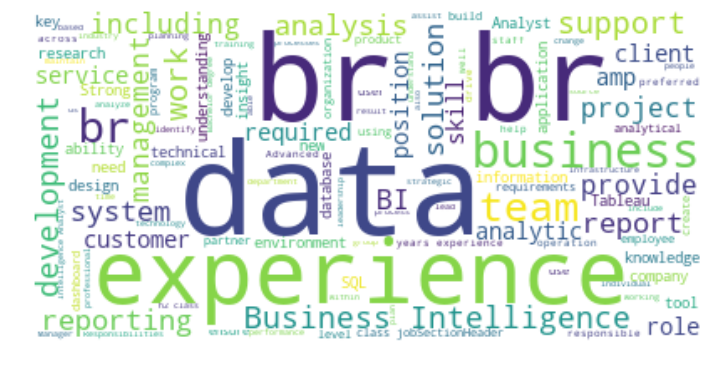

Search Role:  Data Analyst


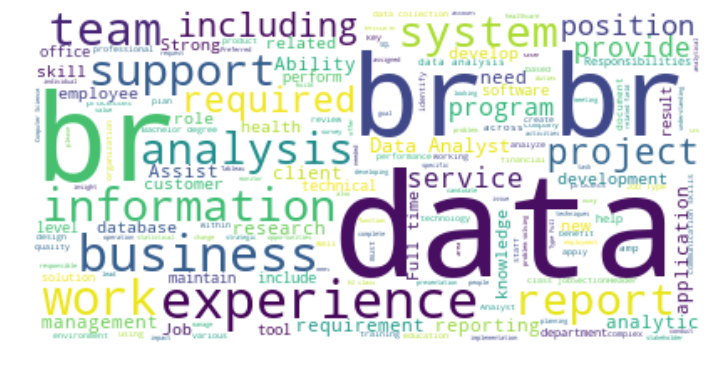

Search Role:  Data Engineer


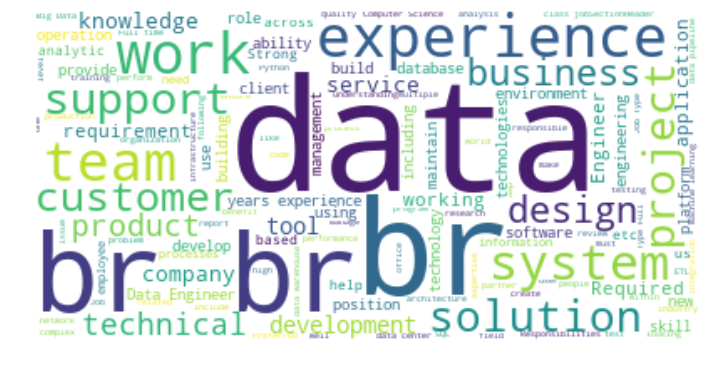

Search Role:  Data Scientist


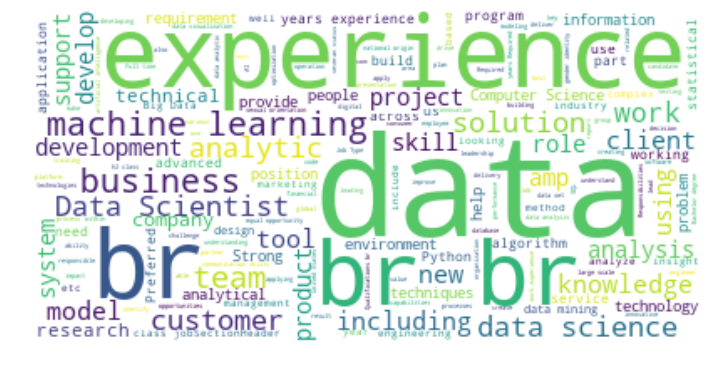

Search Role:  Machine Learning Engineer


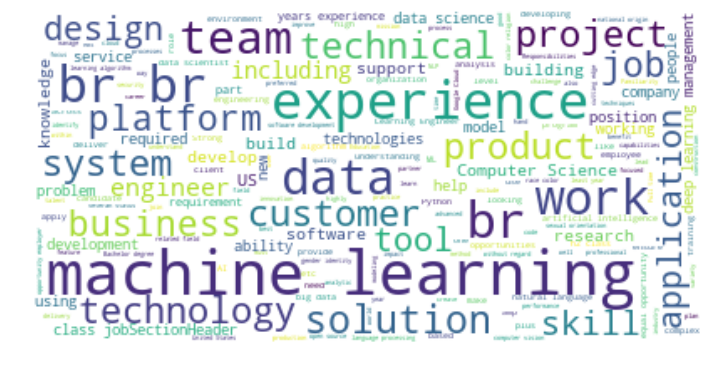

Search Role:  Machine Learning Scientist


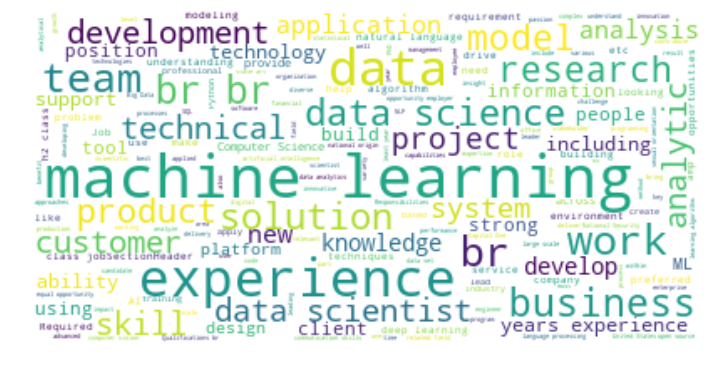

Search Role:  Risk Analyst


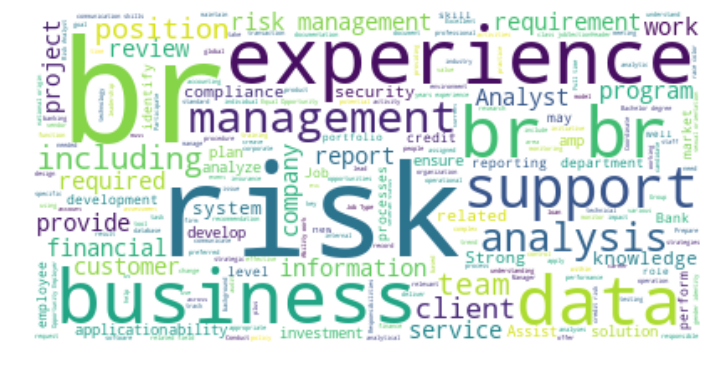

Search Role:  Statistical Modeler


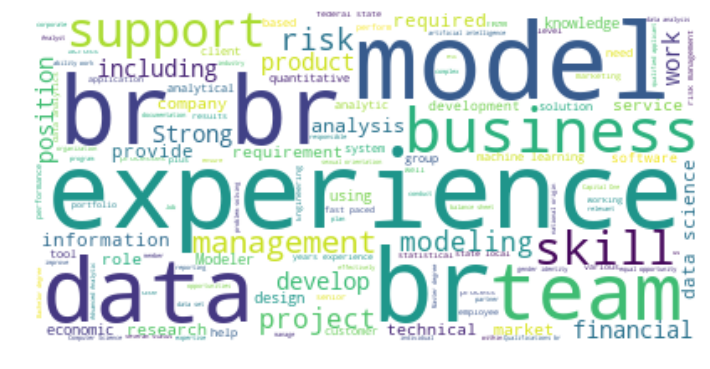

In [204]:
def create_wordcloud(text):
    # Start with one review:
    #text = descriptions[0]

    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords = en_stop, background_color='white').generate(text)

    # Display the generated image:
    plt.figure( figsize=(12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    
    plt.axis("off")
    plt.show()
    
for i, merged_text in enumerate(descriptions):
    print('Search Role: ', roles[i])
    create_wordcloud(merged_text)

### LDA With Gensim

list of tokens -> bag-of-words corpus -> dictionary -> bag-of-words corpus -> LDA model



from LDA model -> extract top topics

In [13]:
# Create a dictionary from the data
dictionary = corpora.Dictionary(desc_tokens)

# Create a bag-of-words corpus 
doc_term_matrix = [dictionary.doc2bow(text) for text in desc_tokens]

In [13]:
doc_term_matrix

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 2),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 3),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 3),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 2),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 2),
  (77, 5),
  (78, 1),
  (79, 1),
  (80, 2),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 2),
  (89, 1),
  (90, 1),
  (91, 1)

In [14]:
#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#dictionary.save('dictionary.gensim')

Documentation

https://radimrehurek.com/gensim/models/ldamodel.html

In [24]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.015*"business" + 0.015*"experience" + 0.008*"solution" + 0.007*"analytics"')
(1, '0.022*"experience" + 0.018*"learning" + 0.014*"machine" + 0.012*"product"')
(2, '0.015*"experience" + 0.008*"project" + 0.007*"require" + 0.007*"years"')
(3, '0.011*"position" + 0.011*"research" + 0.011*"experience" + 0.010*"information"')
(4, '0.009*"experience" + 0.008*"report" + 0.008*"skill" + 0.007*"information"')
(5, '0.038*"learning" + 0.033*"machine" + 0.022*"experience" + 0.016*"research"')
(6, '0.018*"business" + 0.010*"financial" + 0.010*"experience" + 0.010*"skill"')
(7, '0.018*"experience" + 0.012*"business" + 0.009*"skill" + 0.007*"years"')
(8, '0.020*"business" + 0.018*"experience" + 0.010*"skill" + 0.010*"analysis"')
(9, '0.018*"experience" + 0.012*"learning" + 0.008*"machine" + 0.008*"engineer"')


## Determining Optimum Number of Topics to Use
### And coherence measurements

As seen on
https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [56]:
def compute_coherence_values(dictionary, doc_term_matrix, desc_tokens, stop, start=2, step=3):
    """
    From: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSi model on range of num_topics 
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=desc_tokens, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [57]:
def plot_graph(desc_tokens,start, stop, step, dictionary, doc_term_matrix):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,desc_tokens,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.figure(figsize=(10,7))
    plt.plot(x, coherence_values)
    plt.title('Coherence Score to Assess Number of Topics')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.show()

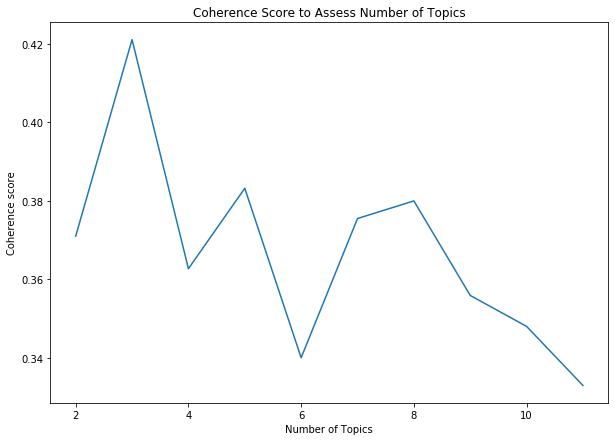

In [60]:

start,stop,step=2,12,1
plot_graph(desc_tokens,start,stop,step, dictionary, doc_term_matrix)

#### Results: 
Optimal number of topics to evaluate is 3

In [61]:
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
#ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
# Create new model using different data set

(0, '0.015*"experience" + 0.012*"learning" + 0.009*"machine" + 0.009*"research"')
(1, '0.011*"experience" + 0.011*"business" + 0.007*"skill" + 0.007*"ability"')
(2, '0.020*"experience" + 0.016*"business" + 0.008*"learning" + 0.007*"customer"')


# pyLDAvis

In [ ]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))
#lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')


In [117]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/ckato/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Text Classification Model
### Using Multinomial Naive Bayes Classification from scikit-learn

As seen on: 
https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk

The following model uses the one-hot-encoded description column in the data frame as the set of X features and evaluates the searched role as the response y variable. 

## 1. Using TF-IDF


In [243]:

vectorizer = TfidfVectorizer()

# generate matrix of word vectors 
tfidf_matrix = vectorizer.fit_transform(descriptions)

print(tfidf_matrix)

  (0, 14940)	0.08239122008492983
  (0, 1460)	0.05572518204914341
  (0, 6728)	0.0030768505425907405
  (0, 6164)	0.0075211902152218105
  (0, 13938)	0.015042380430443621
  (0, 3440)	0.005469956520161317
  (0, 12948)	0.00041047603120061355
  (0, 7097)	0.23589187493195676
  (0, 9882)	0.07999811410735926
  (0, 9341)	0.03828969564112922
  (0, 15211)	0.005469956520161317
  (0, 9503)	0.004119018103488565
  (0, 9608)	0.0034187228251008226
  (0, 8324)	0.007179317932711728
  (0, 5993)	0.11726219290095823
  (0, 10081)	0.004102467390120987
  (0, 15165)	0.004716366731527233
  (0, 1271)	0.6293868721010615
  (0, 11757)	0.016380984458015866
  (0, 15021)	0.015384252712953702
  (0, 15043)	0.059485777156754314
  (0, 3688)	0.01059804075781255
  (0, 3130)	0.0006837445650201646
  (0, 9366)	0.0013754211903497687
  (0, 1798)	0.0016472799395632468
  :	:
  (9, 13978)	0.0008829921854339337
  (9, 14507)	0.0008829921854339337
  (9, 11957)	0.0008829921854339337
  (9, 6884)	0.0017659843708678674
  (9, 8352)	0.00088299

In [259]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(df['description'])

# Build the training and sets using the one-hot-encoded TF-IDF vectorizer
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, df['search_role'], test_size=0.3, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.3665480427046263


## 2. Using Bag of Words


In [253]:
# You can generate document term matrix by using scikit-learn's CountVectorizer.
#tokenizer to remove unwanted elements from out data like symbols and numbers
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['description'])


In [256]:


X_train, X_test, y_train, y_test = train_test_split(
    text_counts, df['search_role'], test_size=0.3, random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.534994068801898


# Conclusions:

Further research ideas:
- Running same things for other careers (ie music/music teaching careers, graphic design)
